In [1]:
import numpy as np
from scipy.sparse import diags, kron, csr_matrix, csc_matrix, identity, block_diag
from scipy.sparse.linalg import spsolve, norm, inv, eigsh, eigs
from numpy import linalg
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd
import seaborn as sns
rc('text', usetex=True) # para usar latex en matplotlib

from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage import convolve
import time
import pickle
import numba 

In [21]:
def A_B(un, a, b, domain, dim, tau, kappa):
    K_dx_minus  = np.array([
        [0,  0, 0],
        [-1, 1, 0],
        [0,  0, 0]
    ])
    K_dx_plus  = np.array([
        [0,  0, 0],
        [0, -1, 1],
        [0,  0, 0]
    ])
    dx_minus = convolve(un.reshape(dim[0], dim[1]), K_dx_minus)
    dx_plus = convolve(un.reshape(dim[0], dim[1]), K_dx_plus)
    dy_minus = convolve(un.reshape(dim[0], dim[1]).T, -K_dx_plus).T
    dy_plus = convolve(un.reshape(dim[0], dim[1]).T, -K_dx_minus).T

    norm_grad = np.sqrt( (np.maximum(dx_minus, 0)**2 + np.minimum(dx_plus, 0)**2) + (np.maximum(dy_minus, 0)**2 + np.minimum(dy_plus, 0)**2) )
    norm_grad[0, :]  = 0
    norm_grad[-1, :] = 0
    norm_grad[:, 0]  = 0
    norm_grad[:, -1] = 0

    K_x_minus  = np.array([
            [0,  0, 0],
            [1, 1, 0],
            [0,  0, 0]
        ])
    K_x_plus  = np.array([
            [0,  0, 0],
            [0, 1, 1],
            [0,  0, 0]
        ])
    
    K_y_minus  = np.array([
            [0, 0, 0],
            [0, 1, 0],
            [0, 1, 0]
        ])
    K_y_plus  = np.array([
            [0, 1, 0],
            [0, 1, 0],
            [0, 0, 0]
        ])
    
    x_minus = convolve(norm_grad, K_x_minus)
    x_plus = convolve(norm_grad, K_x_plus)
    y_minus = convolve(norm_grad, K_x_plus)
    y_plus = convolve(norm_grad, K_x_minus)
    
    hm_x_minus = (2/x_minus) 
    hm_x_minus[np.isclose(norm_grad, 0)] = 0
    hm_x_plus = (2/x_plus) 
    hm_x_plus[np.isclose(norm_grad, 0)] = 0
    hm_y_minus = (2/y_minus) 
    hm_y_minus[np.isclose(norm_grad, 0)] = 0
    hm_y_plus = (2/y_plus) 
    hm_y_plus[np.isclose(norm_grad, 0)] = 0
    
    hm_sum = hm_x_minus + hm_x_plus + hm_y_minus + hm_y_plus
    
    def get_A_row(row):
        px = row
        
        D   = (- a.reshape((dim[0], dim[1])) * norm_grad * hm_sum    )[px, :]
        D1  = (  a.reshape((dim[0], dim[1])) * norm_grad * hm_x_plus )[px, :-1]
        D_1 = (  a.reshape((dim[0], dim[1])) * norm_grad * hm_x_minus)[px, 1:]

        k = np.array([D_1, D, D1], dtype= object)
        offset = [-1, 0, 1]
        
        return diags(k, offset)
    
    def get_A_star_row(row, star):
        px = row
        if star == 1: 
            D = (a.reshape((dim[0], dim[1])) * norm_grad * hm_y_plus )[px, :]
        elif star == -1:
            D = (a.reshape((dim[0], dim[1])) * norm_grad * hm_y_minus)[px, :]
        
        k = D
        offset = 0
        
        return diags(k, offset)
    
    D   = [ get_A_row(row) for row in range( dim[0] ) ]                                                    
    D1  = [csr_matrix(np.zeros((dim[1], dim[1])))] + [ get_A_star_row(row, star=1) for row in range( dim[0] - 1 ) ] + [csr_matrix(np.zeros((dim[1], dim[1])))]
    D_1 = [csr_matrix(np.zeros((dim[1], dim[1])))] + [ get_A_star_row(row, star=-1) for row in range(1, dim[0] ) ] + [csr_matrix(np.zeros((dim[1], dim[1])))]

    A0 = block_diag(D)
    A1 = csr_matrix(block_diag(D1).todense()[dim[1]:,:-dim[1]])
    A2 = csr_matrix(block_diag(D_1).todense()[:-dim[1],dim[1]:])
    
    I = csr_matrix(np.eye(un.shape[0]))
    A_star = I - (tau * csr_matrix(A0+A1+A2))

    B_star = un + (tau*kappa*np.ravel(norm_grad)*a)

    return A_star, B_star, norm_grad
    

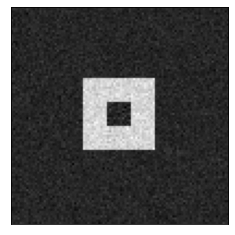

In [22]:
dim = (100, 100)
domain = [ 
    (x, y) for x in range( dim[0] ) for y in range( dim[1] )
]

img = np.random.normal(0.4, 0.005, size=dim[0] * dim[1])
for i in range(dim[0]//3):
    for j in range(dim[1]//3):
        img[(i+dim[0]//3)*dim[1]+j+dim[1]//3] += np.random.normal(0.1, 0.005)

for i in range(dim[0]//9):
    for j in range(dim[1]//9):
        img[(i+4*dim[0]//9)*dim[1]+j+4*dim[1]//9] -= np.random.normal(0.1, 0.005)

display(plt.imshow(img.reshape(dim[0], dim[1]), cmap='gray'))
plt.xticks([]);
plt.yticks([]);
# plt.savefig("img02.png", bbox_inches='tight')

In [4]:
def stopping_func(img, dim, domain, sgm=0.5, lmbd=1):
    blurred = gaussian_filter(img.reshape(dim[0], dim[1]), sigma=sgm).flatten()
    f_sgm = blurred
    
    K_dx_minus  = np.array([
        [0,  0, 0],
        [-1, 1, 0],
        [0,  0, 0]
    ])
    K_dx_plus  = np.array([
        [0,  0, 0],
        [0, -1, 1],
        [0,  0, 0]
    ])
    dx_minus = convolve(f_sgm.reshape(dim[0], dim[1]), K_dx_minus)
    dx_plus = convolve(f_sgm.reshape(dim[0], dim[1]), K_dx_plus)
    dy_minus = convolve(f_sgm.reshape(dim[0], dim[1]).T, -K_dx_plus).T
    dy_plus = convolve(f_sgm.reshape(dim[0], dim[1]).T, -K_dx_minus).T

    norm_grad = np.sqrt( (np.maximum(dx_minus, 0)**2 + np.minimum(dx_plus, 0)**2) + (np.maximum(dy_minus, 0)**2 + np.minimum(dy_plus, 0)**2) )
    norm_grad[0, :] = 0
    norm_grad[-1, :] = 0
    norm_grad[:, 0] = 0
    norm_grad[:, -1] = 0
    
    norm_grad = np.ravel(norm_grad)
    
    g = 1 + (norm_grad**2) / (lmbd**2)
    g = 1/g
    
    return (g, blurred)

<ipython-input-4-0871aa7e195f>:28: RuntimeWarning: divide by zero encountered in true_divide
  g = 1 + (norm_grad**2) / (lmbd**2)
<ipython-input-4-0871aa7e195f>:28: RuntimeWarning: invalid value encountered in true_divide
  g = 1 + (norm_grad**2) / (lmbd**2)


Wall time: 4.8 s


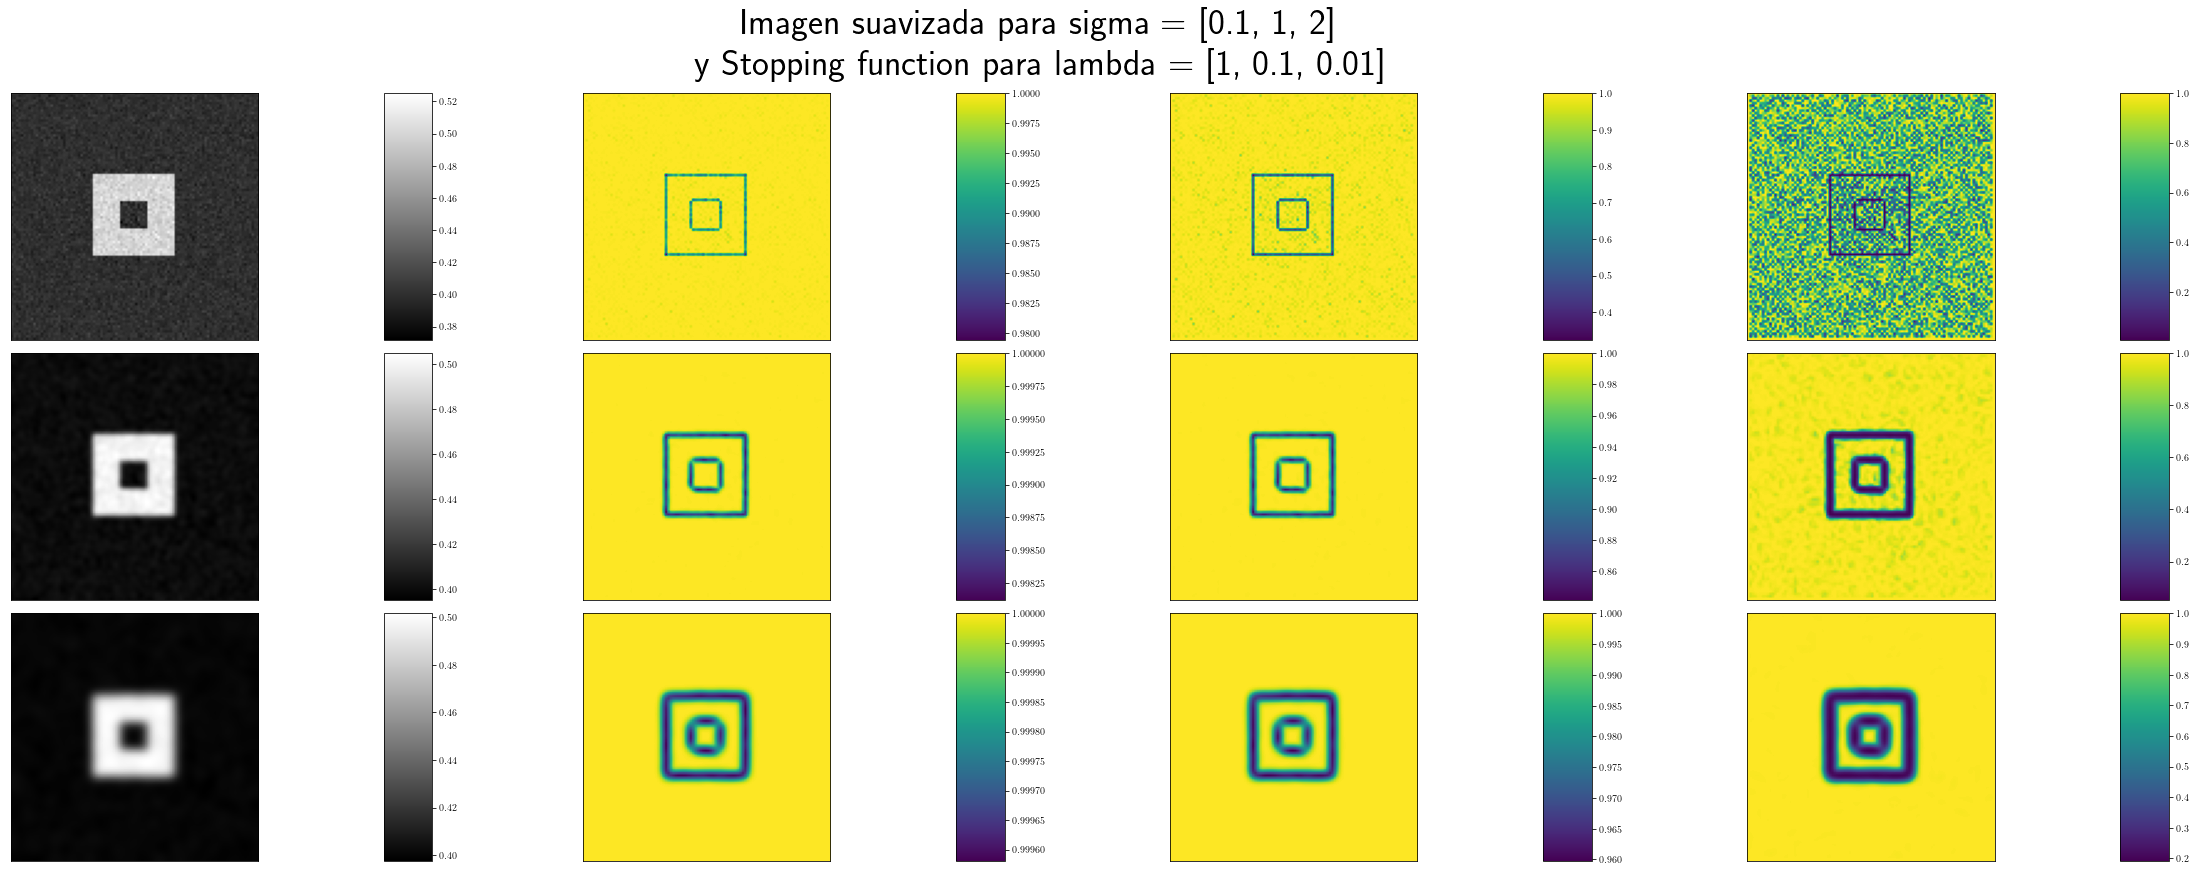

In [5]:
%%time
fig, ax = plt.subplots(3, 4*2, figsize=(4*2*4, 3*4), constrained_layout=True, 
                       gridspec_kw={"width_ratios": [1, 0.1, 1, 0.1, 1, 0.1, 1, 0.1]})
for i, sgm in enumerate([0.1, 1, 2]):
    for j, lmbd in enumerate([0, 1, 0.1, 0.01]):
        g, blurred = stopping_func(img, dim, domain, sgm=sgm, lmbd=lmbd)
        if j == 0:
            im = ax[i, j*2].imshow(blurred.reshape(dim[0], dim[1]), cmap='gray')
        else:
            im = ax[i, j*2].imshow(g.reshape(dim[0], dim[1]))
        fig.colorbar(im, cax=ax[i, j*2+1], orientation='vertical')
        ax[i, j*2].set_xticks([])
        ax[i, j*2].set_yticks([])
plt.suptitle("Imagen suavizada para sigma = [0.1, 1, 2] \ny Stopping function para lambda = [1, 0.1, 0.01]", size=18*2)
plt.savefig("stopping_function2.png", bbox_inches='tight');

In [6]:
def initial_curve(x0, r, domain, dim):
    u0 = np.zeros(len(domain))
    for p in domain:
        x = (p[0]/(dim[0]-1), p[1]/(dim[1]-1))
        sgn = 0
        if (x[0]-x0[0]) ** 2 + (x[1]-x0[1]) ** 2 < r ** 2:
            sgn = 1
        else:
            sgn = -1
        dist = abs(r-linalg.norm([x[0]-x0[0], x[1]-x0[1]]))
        ix = domain.index(p)
        u0[ix] = sgn * dist
    return u0

Wall time: 2.25 s


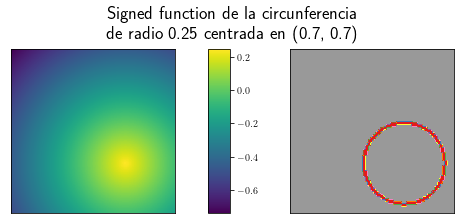

In [7]:
%%time
u0 = initial_curve((0.7, 0.7), 0.25, domain, dim)
fig, ax = plt.subplots(1, 3, figsize=(3.5*2, 3), constrained_layout=True, gridspec_kw={"width_ratios": [1, 0.1, 1]})
im = ax[0].imshow(u0.reshape(dim[0], dim[1]))
ax[0].set_xticks([])
ax[0].set_yticks([])
fig.colorbar(im, cax=ax[1], orientation='vertical')
cv0 = np.isclose(u0, 0, atol=0.01)
ax[2].imshow(cv0.reshape(dim[0], dim[1]), cmap="Set1_r")
ax[2].set_xticks([])
ax[2].set_yticks([]);
plt.suptitle("Signed function de la circunferencia \nde radio 0.25 centrada en (0.7, 0.7)", size=18)
# plt.tight_layout();
plt.savefig("u0.png", bbox_inches='tight');

<ipython-input-21-d50956e3ddd8>:50: RuntimeWarning: divide by zero encountered in true_divide
  hm_x_minus = (2/x_minus)
<ipython-input-21-d50956e3ddd8>:52: RuntimeWarning: divide by zero encountered in true_divide
  hm_x_plus = (2/x_plus)
<ipython-input-21-d50956e3ddd8>:54: RuntimeWarning: divide by zero encountered in true_divide
  hm_y_minus = (2/y_minus)
<ipython-input-21-d50956e3ddd8>:56: RuntimeWarning: divide by zero encountered in true_divide
  hm_y_plus = (2/y_plus)


Wall time: 5.96 s


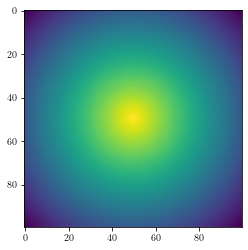

In [30]:
%%time
tau = 5
kappa=-0.1
a, img_blurred = stopping_func(img, dim, domain, sgm=0.5, lmbd=0.01)
b = np.ones( dim[0] * dim[1] )

u0 = initial_curve((0.5, 0.5), 0.3, domain, dim)

A0_star, B0_star, norm_grad = A_B(u0, a, b, domain, dim, tau, kappa)
plt.imshow(B0_star.reshape((dim[0], dim[1])))

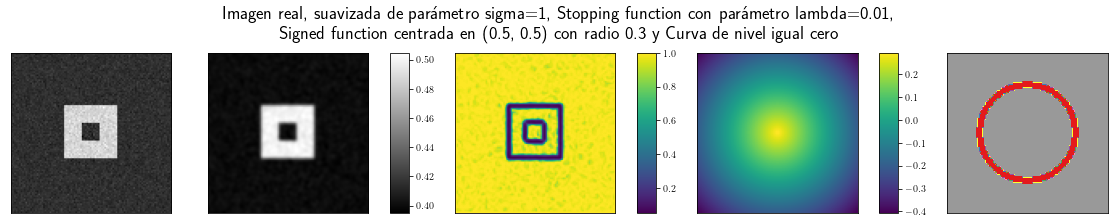

In [9]:
fig, ax = plt.subplots(1, 8, figsize=(5*3+3*0.25, 3), constrained_layout=True, gridspec_kw={"width_ratios": [1, 1, 0.1, 1, 0.1, 1, 0.1, 1]})

ax[0].imshow(img.reshape(dim[0], dim[1]), cmap="gray")
ax[0].set_xticks([])
ax[0].set_yticks([])

im = ax[1].imshow(img_blurred.reshape(dim[0], dim[1]), cmap="gray")
ax[1].set_xticks([])
ax[1].set_yticks([]);
fig.colorbar(im, cax=ax[2], orientation='vertical')

im = ax[3].imshow(a.reshape(dim[0], dim[1]))
ax[3].set_xticks([])
ax[3].set_yticks([]);
fig.colorbar(im, cax=ax[4], orientation='vertical')

im = ax[5].imshow(u0.reshape(dim[0], dim[1]))
ax[5].set_xticks([])
ax[5].set_yticks([])
fig.colorbar(im, cax=ax[6], orientation='vertical')

cv0 = np.isclose(u0, 0, atol=0.02)
ax[7].imshow(cv0.reshape(dim[0], dim[1]), cmap="Set1_r")
ax[7].set_xticks([])
ax[7].set_yticks([]);

plt.suptitle("Imagen real, suavizada de parámetro sigma=1, Stopping function con parámetro lambda=0.01, \nSigned function centrada en (0.5, 0.5) con radio 0.3 y Curva de nivel igual cero", size=18)
plt.savefig("init_exp5.png", bbox_inches='tight');

In [31]:
un = u0
iterations = [u0]
times = [0]

<ipython-input-21-d50956e3ddd8>:50: RuntimeWarning: divide by zero encountered in true_divide
  hm_x_minus = (2/x_minus)
<ipython-input-21-d50956e3ddd8>:52: RuntimeWarning: divide by zero encountered in true_divide
  hm_x_plus = (2/x_plus)
<ipython-input-21-d50956e3ddd8>:54: RuntimeWarning: divide by zero encountered in true_divide
  hm_y_minus = (2/y_minus)
<ipython-input-21-d50956e3ddd8>:56: RuntimeWarning: divide by zero encountered in true_divide
  hm_y_plus = (2/y_plus)


n: 0 time: 4.70641565322876
n: 1 time: 4.432182550430298
n: 2 time: 4.632631778717041
n: 3 time: 4.356383800506592
n: 4 time: 4.415133476257324
n: 5 time: 4.276183366775513
n: 6 time: 4.334887742996216
n: 7 time: 4.333439111709595
n: 8 time: 4.208758354187012
n: 9 time: 4.573679685592651
n: 10 time: 4.295199871063232
n: 11 time: 4.456650257110596
n: 12 time: 4.522933006286621
n: 13 time: 4.202760696411133
n: 14 time: 4.0741071701049805
n: 15 time: 4.393762588500977
n: 16 time: 4.634582757949829
n: 17 time: 4.186917304992676
n: 18 time: 4.262561559677124
n: 19 time: 4.754348278045654


<timed exec>:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


n: 20 time: 4.89549446105957
n: 21 time: 4.67056131362915
n: 22 time: 4.408159971237183
n: 23 time: 4.1549975872039795
n: 24 time: 4.095020532608032
n: 25 time: 4.021291255950928
n: 26 time: 4.203279733657837
n: 27 time: 4.041236400604248
n: 28 time: 4.0848448276519775
n: 29 time: 4.400260925292969
n: 30 time: 4.860853672027588
n: 31 time: 4.225455045700073
n: 32 time: 4.411057710647583
n: 33 time: 4.201778888702393
n: 34 time: 4.291180849075317
n: 35 time: 4.519941091537476
n: 36 time: 4.068865776062012
n: 37 time: 4.348273038864136
n: 38 time: 4.140645980834961
n: 39 time: 4.069174289703369
n: 40 time: 3.9683828353881836
n: 41 time: 4.236671447753906
n: 42 time: 4.273427963256836
n: 43 time: 4.101363897323608
n: 44 time: 4.2276952266693115
n: 45 time: 4.6331870555877686
n: 46 time: 4.341550827026367
n: 47 time: 4.505443572998047
n: 48 time: 4.238684177398682
n: 49 time: 4.125301122665405
Wall time: 3min 36s


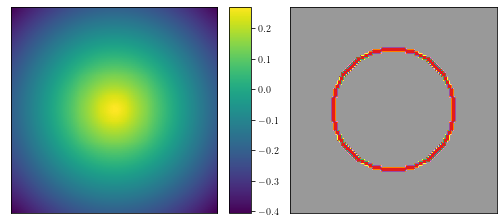

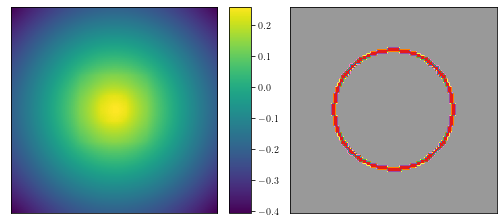

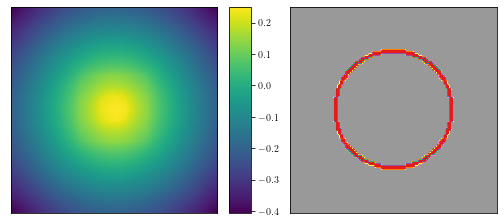

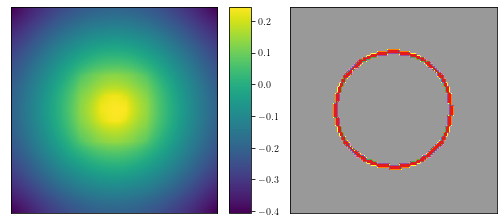

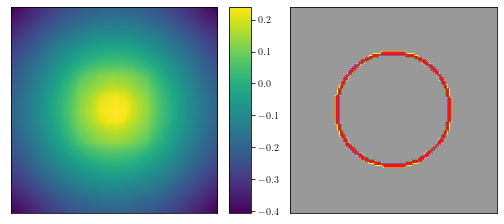

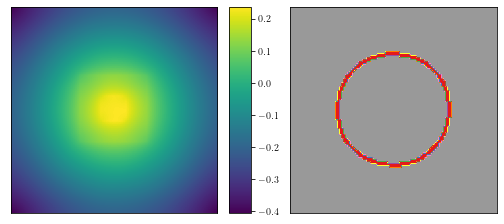

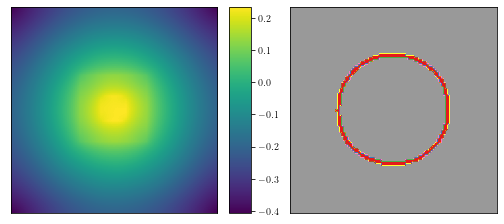

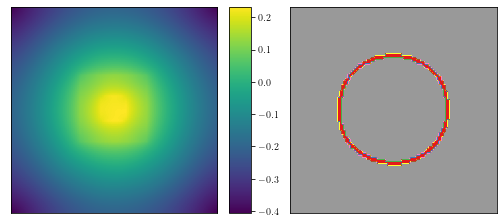

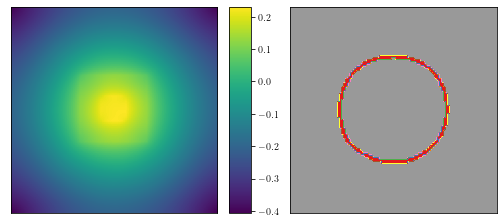

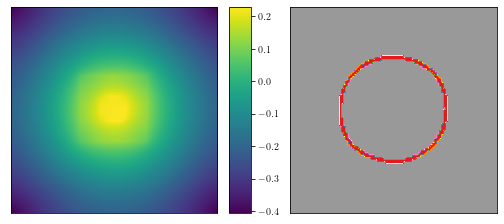

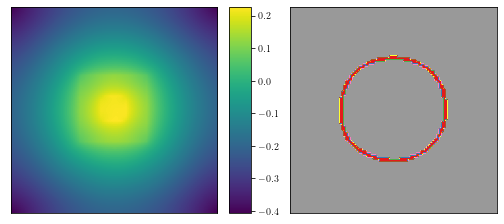

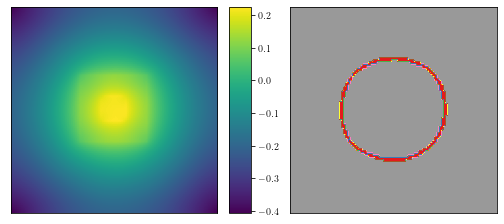

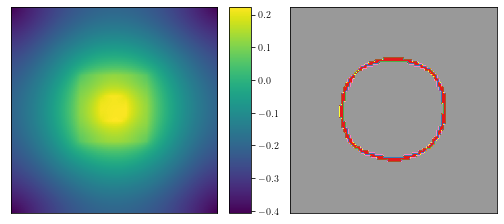

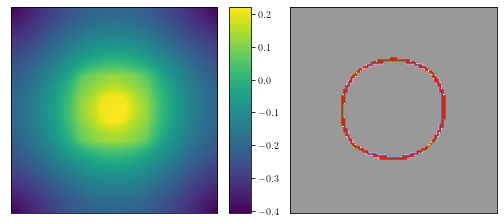

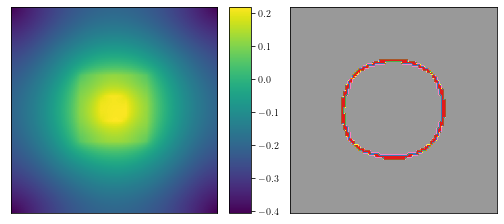

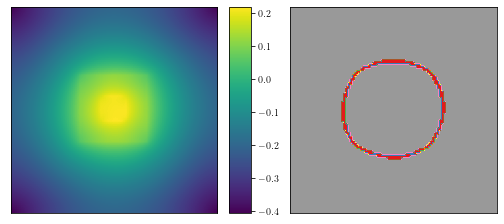

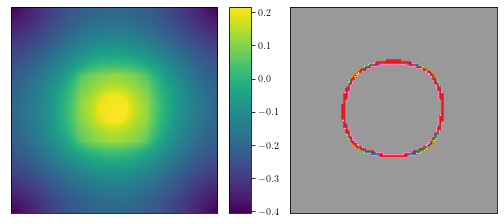

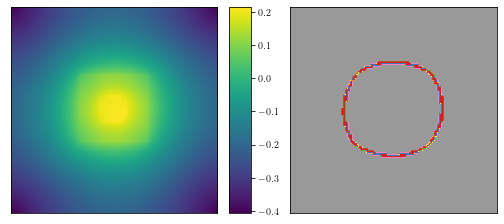

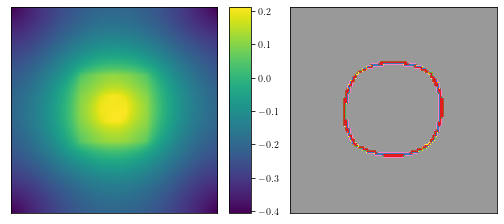

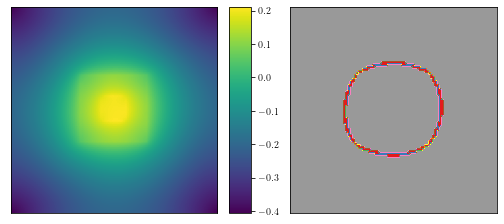

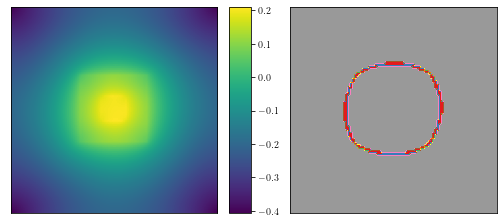

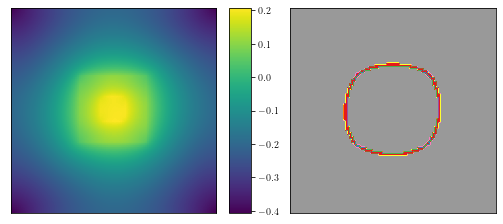

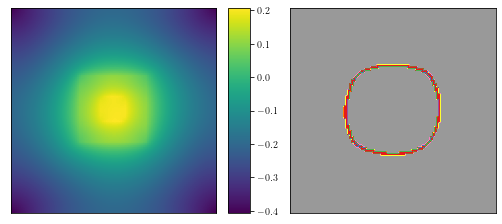

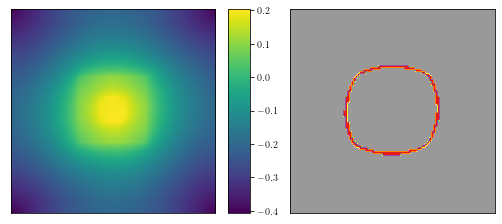

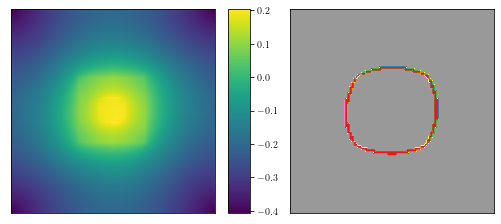

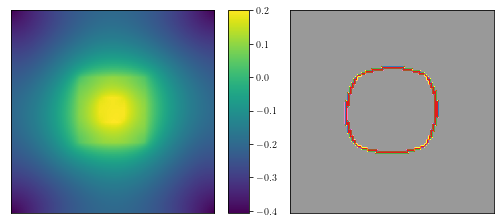

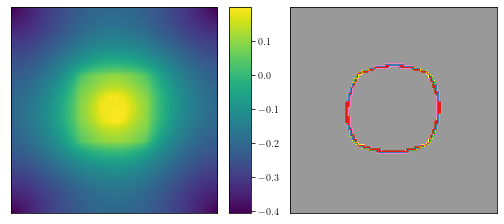

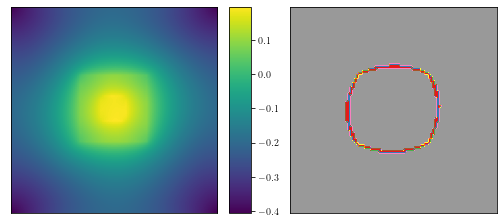

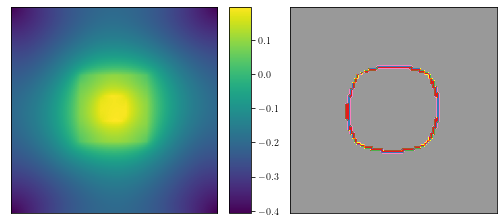

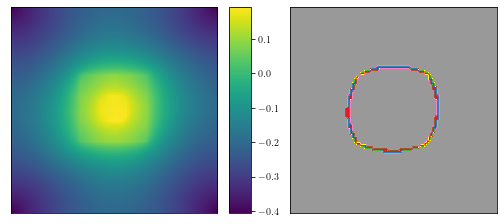

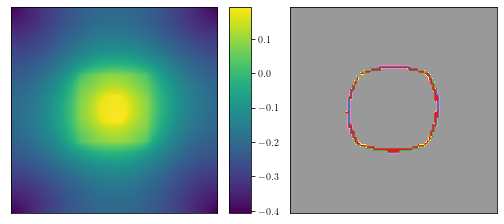

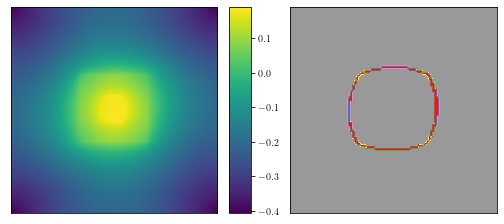

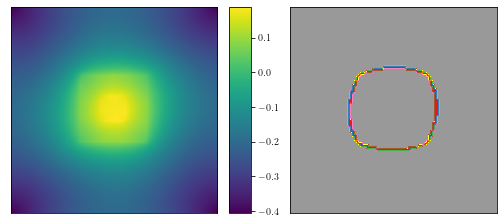

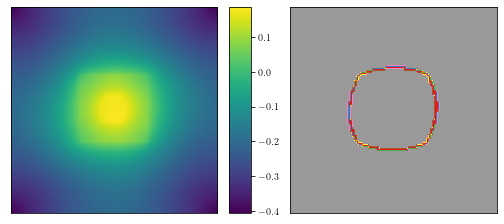

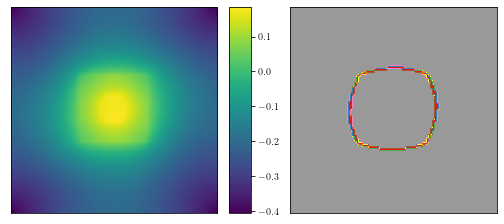

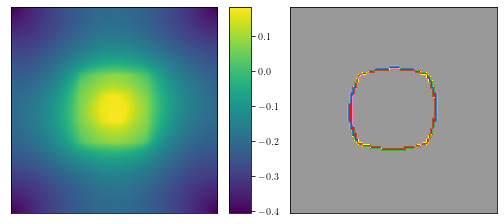

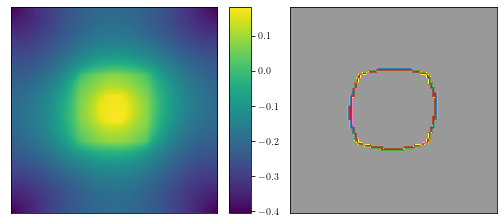

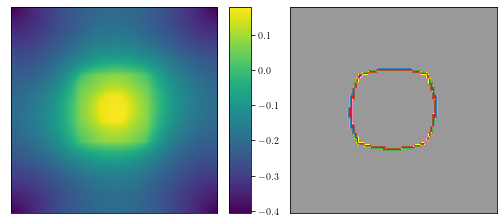

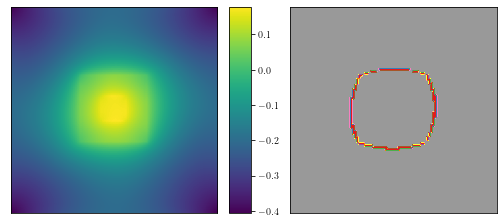

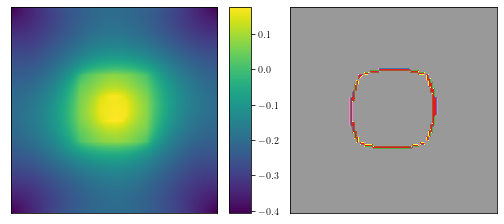

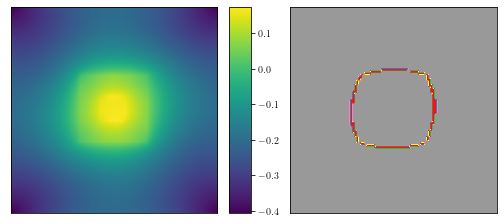

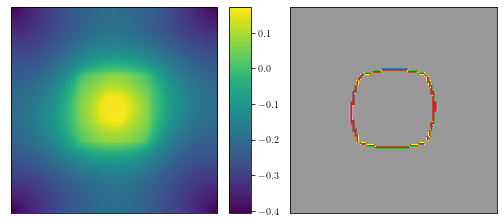

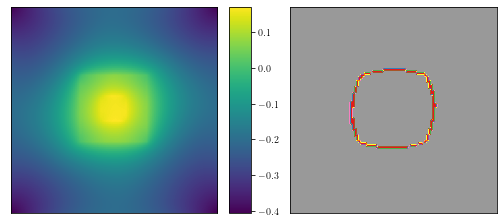

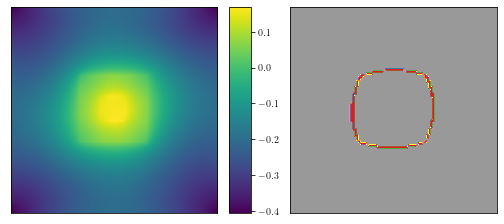

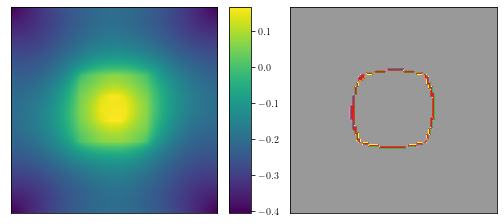

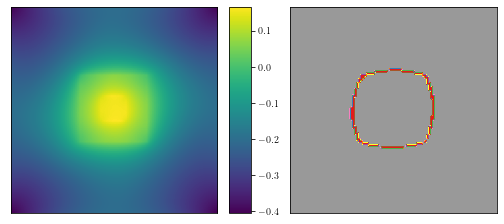

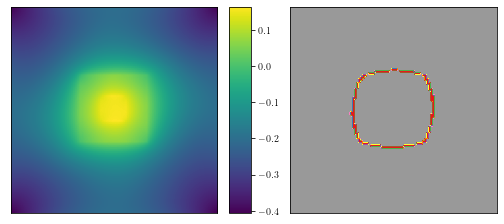

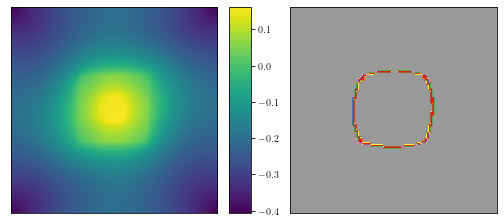

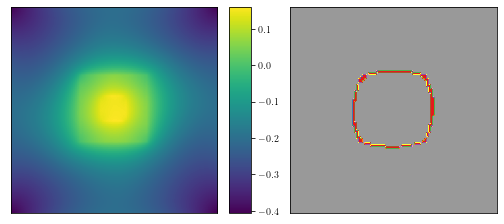

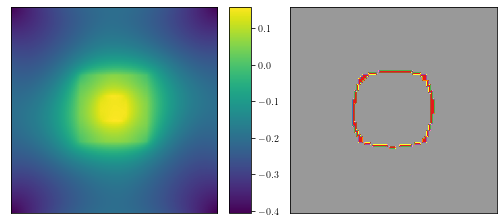

In [32]:
%%time
for n in range(50):
    
    start = time.time()
    An_star, Bn_star, _ = A_B(un, a, b, domain, dim, tau, kappa)
    un1 = spsolve(An_star, Bn_star)
    cvn = np.isclose(un1, 0, atol=0.01)

    fig, ax = plt.subplots(1, 3, figsize=(3.5*2, 3), constrained_layout=True, gridspec_kw={"width_ratios": [1, 0.1, 1]})
    im = ax[0].imshow(un1.reshape(dim[0], dim[1]))
    ax[0].set_xticks([]);
    ax[0].set_yticks([]);
    fig.colorbar(im, cax=ax[1], orientation='vertical')

    ax[2].imshow(cvn.reshape(dim[0], dim[1]), cmap="Set1_r")
    ax[2].set_xticks([]);
    ax[2].set_yticks([]);

    plt.savefig(f"image_test6/un_{n}.png", bbox_inches='tight');

    un = un1
    iterations.append(un)
    end = time.time()
    
    times.append(end-start)
    print("n:", n, "time:", times[-1])

In [12]:
pickle.dump(iterations, open("iterations0.pickle", "wb"))
pickle.dump(times, open("times0.pickle", "wb"))

mean: 4.435988467672597 std: 0.2032612529676229


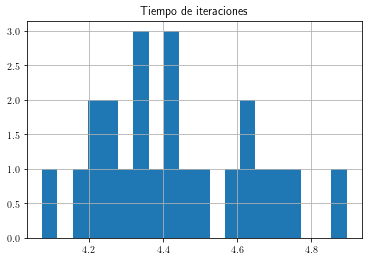

In [33]:
rel_times = times[1:23+1]
pd.DataFrame(rel_times, columns=["Tiempo de iteraciones"]).hist(bins=20);
print("mean:", np.mean(rel_times), "std:", np.std(rel_times))

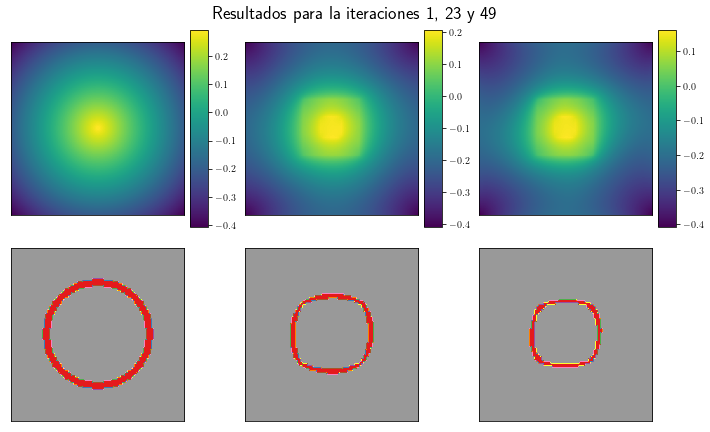

In [35]:
fig, ax = plt.subplots(2, 6, figsize=(3*3+3*0.25, 3*2), constrained_layout=True, gridspec_kw={"width_ratios": [1, 0.1, 1, 0.1, 1, 0.1]})

# Funciones
im = ax[0, 0].imshow(iterations[0].reshape(dim[0], dim[1]))
ax[0, 0].set_xticks([])
ax[0, 0].set_yticks([])

fig.colorbar(im, cax=ax[0, 1], orientation='vertical')

im = ax[0, 2].imshow(iterations[23].reshape(dim[0], dim[1]))
ax[0, 2].set_xticks([])
ax[0, 2].set_yticks([])

fig.colorbar(im, cax=ax[0, 3], orientation='vertical')

im = ax[0, 4].imshow(iterations[49].reshape(dim[0], dim[1]))
ax[0, 4].set_xticks([])
ax[0, 4].set_yticks([])

fig.colorbar(im, cax=ax[0, 5], orientation='vertical')

# Curvas
im = ax[1, 0].imshow(np.isclose(iterations[0], 0, atol=0.02).reshape(dim[0], dim[1]), cmap="Set1_r")
ax[1, 0].set_xticks([])
ax[1, 0].set_yticks([])

im = ax[1, 2].imshow(np.isclose(iterations[23], 0, atol=0.02).reshape(dim[0], dim[1]), cmap="Set1_r")
ax[1, 2].set_xticks([])
ax[1, 2].set_yticks([])

im = ax[1, 4].imshow(np.isclose(iterations[49], 0, atol=0.02).reshape(dim[0], dim[1]), cmap="Set1_r")
ax[1, 4].set_xticks([])
ax[1, 4].set_yticks([])

for axc in [ax[1, 1], ax[1, 3], ax[1, 5]]:
    axc.remove()

plt.suptitle("Resultados para la iteraciones 1, 23 y 49", size=18)
plt.savefig("res_exp5.png", bbox_inches='tight');